# This Notebook requires that the data and the model definition is placed in a shared filesystem on the server.
### For example if your shared FS is mounted at /shared you could do it like this

Log in to the system and execute the following:

```
[root@p621-met1 shared]# cd /shared
/shared
[root@p621-met1 shared]# yum install unzip -y
[root@p621-met1 shared]# wget https://github.com/mgiessing/WMLA/raw/master/CIFAR10-images.zip
[root@p621-met1 shared]# unzip CIFAR10-images.zip
```

````
[root@p621-met1 shared]# wget https://github.com/mgiessing/WMLA/raw/master/pytorch_resnet.zip
[root@p621-met1 shared]# unzip pytorch_resnet.zip
````

In [1]:
import requests
import json
import time
import warnings
warnings.filterwarnings('ignore')
#Construct API call

### *** USER INPUT TO THE FOLLOWING VARIABLES *** ###

master_host = 'p621-kvm1.p621.cecc.ihost.com' # REQUIRED: Adjust to your host

dli_rest_port = '9243'  #Deep Learning Impact Rest API Port
sc_rest_port = '8643' #Conductor Rest API Port

#Following config assumes SSL enabled and default ports
sc_rest_url = 'https://'+master_host+':'+sc_rest_port+'/platform/rest/conductor/v1'
dl_rest_url = 'https://'+master_host+':'+dli_rest_port+'/platform/rest/deeplearning/v1'

# User login details
wmla_user = 'Admin'
wmla_pwd = 'Admin'

# Instance Group to be used
sig_name =  'ig-dli' 

dsname = 'CIFAR-10-MG' # Choose anything meaningful, e.g. replace MG with your credentials
modelname = "resnet-18" # Choose anything meaningful or let as-is (since the model is resnet-18...)

#KEEP IN MIND THE FOLLOWING MUST BE ON SHARED FILESYSTEM, in my case it is mounted at /shared
trainpath = '/shared/CIFAR-10-images/train' # Path where you uploaded the (train)data 
modelpath = '/shared/resnet' # Path where you uploaded the model definition

### --------------------------------------------- ###

myauth = (wmla_user, wmla_pwd)

# REST call variables
headers = {'Accept': 'application/json'}
print (sc_rest_url)
print (dl_rest_url)

https://p621-kvm1.p621.cecc.ihost.com:8643/platform/rest/conductor/v1
https://p621-kvm1.p621.cecc.ihost.com:9243/platform/rest/deeplearning/v1


## Initial configuration for creating the dataset

In [2]:
def get_sigid(sig_name):
    r = requests.get(dl_rest_url + '/scheduler/instances', auth=myauth, verify=False, headers=headers)
    res = json.loads(r.text)
    for item in res:
        if item['name'] == sig_name:
            print("Found the sigid of {} which is {}".format(sig_name, item['uuid']))
            return item['uuid']
    
    print("There is no instance group named {}\nChoose one of these:".format(sig_name))
    for item in res:
        print(item['name'])

sigid = get_sigid(sig_name)

#Construct dictionary that will create the sample datasets
data = {
  "name": dsname,
  "dbbackend": "TFRecords",
  "trainpath": trainpath,
  "sigid": sigid,
  "imagedetail": {
        "isusingtext": "false",
        "trainimagepath": trainpath,
        "imagetype": "Color",
        "height": 0,
        "width": 0,
        "resizetransformation": "Squash",
        "testpercentage": 10,
        "splitalgorithm": "hold-out"
    },
  "byclass": "true",
  "datasourcetype": "IMAGEFORCLASSIFICATION"
}
print("\n",data)

Found the sigid of ig-dli which is 446d4bcc-da18-4695-8020-549f1baf3441

 {'name': 'CIFAR-10-MG', 'dbbackend': 'TFRecords', 'trainpath': '/shared/CIFAR-10-images/train', 'sigid': '446d4bcc-da18-4695-8020-549f1baf3441', 'imagedetail': {'isusingtext': 'false', 'trainimagepath': '/shared/CIFAR-10-images/train', 'imagetype': 'Color', 'height': 0, 'width': 0, 'resizetransformation': 'Squash', 'testpercentage': 10, 'splitalgorithm': 'hold-out'}, 'byclass': 'true', 'datasourcetype': 'IMAGEFORCLASSIFICATION'}


# Step 1: Get datasets or create it

In [3]:
r = requests.get(dl_rest_url + '/datasets', auth=myauth, verify=False, headers=headers)
res = json.loads(r.text)

print(f'Found {len(res)} dataset/s')
if len(res) > 0:
    for item in res:
        if item['status'] == 'FINISHED':
            print(json.dumps(item, indent=4))
        else:
            print('Dataset not successfully finished\n {}'.format(json.dumps(item, indent=4)))
else:
    print("Didn't find any dataset on server. Will create one...\n")
    r = requests.post(url=dl_rest_url + '/datasets', auth=myauth, json=data, headers=headers, verify=False)
    if r.ok is True:
        print("Creating dataset, this might take about 2-3 minutes")
        while json.loads(requests.get(dl_rest_url + '/datasets', auth=myauth, verify=False, headers=headers).text)[0]['status'] != "FINISHED":
            print("Creating")
            time.sleep(15)
        print("Finished!")
    else:
        print("Something went wrong!")

Found 0 dataset/s
Didn't find any dataset on server. Will create one...

Creating dataset, this might take about 2-3 minutes
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Finished!


# Step 2: Model Management: Modeltemplate -> Model -> Modeltraining

## Step 2.1: Get modeltemplate or create it


In [4]:
data = {
  "name": "resnet",
  "path": modelpath,
  "framework": "PyTorch",
}

r = requests.get(dl_rest_url + '/modeltemplates', auth=myauth, verify=False, headers=headers)
res = json.loads(r.text)

if not res:
    print("No modeltemplate found, will create one...")
    r = requests.post(url=dl_rest_url + '/modeltemplates', auth=myauth, json=data, headers=headers, verify=False)
    if r.ok is True:
        print("Modeltemplate created!")
    else:
        print("Could not create model because:\n",r.text)
else:
    print("Found {} modeltemplate/s:".format(len(res)))
    for item in res:
        print(json.dumps(item, indent=2))

No modeltemplate found, will create one...
Modeltemplate created!


 ## 2.2 Get model or create one

In [5]:
data = {
  "name": modelname,
  "templatename": "PyTorch-resnet",
  "sig": "446d4bcc-da18-4695-8020-549f1baf3441",
  "accelerator": "Single",
  "hyperparameter": {
    "learningrate": 0.01,
    "momentum": 0.0,
    "epoch": 10,
    "weightdecay": 0.0,
    "solvertype": "SGD",
    "lrpolicy": "fixed",
    "nesterov": "false",
    "dampening": 0.0
  },
  "dataset": "CIFAR-10-MG",
  "batchsize": 32,
  "type": "Training",
}

# There are tons of hyperparams which can be configured - see ref: https://<HOST>:9243/cloud/apis/explorer/

In [6]:
r = requests.get(dl_rest_url + '/models', auth=myauth, verify=False, headers=headers)
res = json.loads(r.text)

if not res:
    print("No model found, will create one...")
    r = requests.post(url=dl_rest_url + '/models', auth=myauth, json=data, headers=headers, verify=False)
    if r.ok is True:
        print("Model created!")
    else:
        print("Could not create model because:\n",r.text)
else:
    for item in res:
        print(json.dumps(item, indent=2))

No model found, will create one...
Model created!


## Step 2.3 Get modeltraining info or start training

In [7]:
data = {
  "trainName": "resnet-10-mg1",
  "dlFramework": "PyTorch",
  "gpuRatio": 1,
  "clusterSize": 1,
  "testInterval": 100,
  "testIteration": 10,
  "syncMode": "SYNC",
  "distribute": "false"
}

In [8]:
r = requests.get(dl_rest_url + '/models/' + modelname + '/trainings', auth=myauth, verify=False, headers=headers)
res = json.loads(r.text)

if not res:
    print("No model training found, will create one...")
    r = requests.post(dl_rest_url + '/models/' + modelname + '/trainings', auth=myauth, json=data, headers=headers, verify=False)
    if r.ok is True:
        print("Model training started! Waiting for 10 seconds to initialize...")
        time.sleep(10) # Needs some seconds to initialize
        r = requests.get(dl_rest_url + '/models/' + modelname + '/trainings', auth=myauth, verify=False, headers=headers)
        res = json.loads((r.text))
    else:
        print("Could not start model training because:\n",r.text)
else:
    for item in res:
        print(json.dumps(item, indent=2))

#trainingsname = res[0]['trainingParameters']['trainName']
appid = res[0]['trainingParameters']['appid']
r = requests.get(dl_rest_url + '/scheduler/applications?applicationid='+appid, auth=myauth, verify=False, headers=headers)
res = json.loads((r.text))
executorid = res[0]['executors'][0]['id']

No model training found, will create one...
Model training started! Waiting for 10 seconds to initialize...


## 2.4 Monitor the training

Current runtime: 20.62 minutes

Iteration:
[1563, 3126, 4689, 6252, 7815, 9378, 10941, 12504, 14067, 15630]
Train accuracy:
[0.4046, 0.565, 0.6457, 0.7022, 0.7456, 0.7792, 0.8067, 0.8309, 0.8516, 0.8697]
Test accuracy:
[0.5002, 0.5172, 0.3733, 0.6478, 0.7317, 0.6659, 0.6095, 0.793, 0.7801]
Train loss:
[1.5966, 1.207, 0.9927, 0.8468, 0.7311, 0.6316, 0.5539, 0.4887, 0.4272, 0.38]
Test loss:
[0.0429, 0.046, 0.0797, 0.033, 0.0243, 0.0334, 0.0485, 0.019, 0.0213]



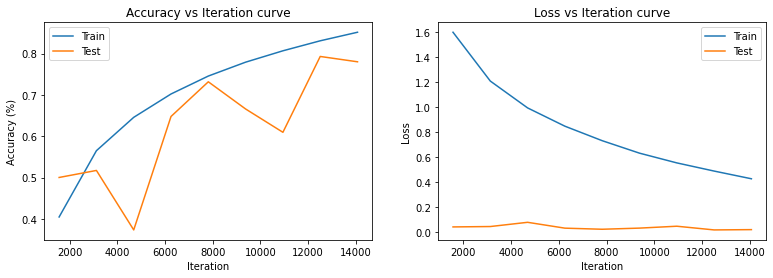

Training finished


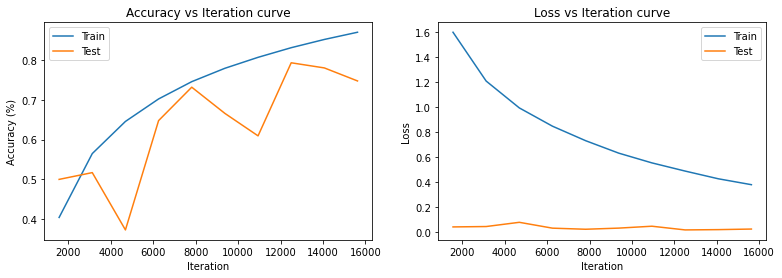

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

def show_graph(iteration, train_acc, test_acc, train_loss, test_loss):
    plt.figure(figsize=(20,4))

    ax1 = plt.subplot(131)
    ax1.plot(iteration, train_acc, label='Train')
    ax1.plot(iteration, test_acc, label='Test')
    ax1.title.set_text('Accuracy vs Iteration curve')
    ax1.legend(loc="upper left")
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Accuracy (%)')
    #ax1.set_ylim([0, 1])

    ax2 = plt.subplot(132)
    ax2.plot(iteration, train_loss, label='Train')
    ax2.plot(iteration, test_loss, label='Test')
    ax2.title.set_text('Loss vs Iteration curve')
    ax2.legend(loc="upper right")
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Loss')
    #ax2.set_ylim([0, 3])

    plt.show()
    
def get_metrics():
    url = sc_rest_url + '/instances/' + sigid + '/applications/' + appid + '/' + executorid + '/logs/stderr?lastlines=1000000'
    txtHeader = {'Accept': 'text/plain'}
    r = requests.get(url=url, auth=myauth, verify=False, headers=txtHeader)
    #res = json.loads((r.text))

    train_acc = []
    test_acc = []
    train_loss = []
    test_loss = []
    iteration = []
    for item in r.text.split("\n"):
        if "train_acc" in item.lower():
            iteration.append(int(item.split(" ")[1].split(":")[0]))
            train_acc.append(round(float(item.split(" ")[5]),4))
        if "test_acc" in item.lower():
            test_acc.append(round(float(item.split(" ")[5]),4))
        if "train_loss" in item.lower():
            train_loss.append(round(float(item.split(" ")[5]),4))
        if "test_loss" in item.lower():
            test_loss.append(round(float(item.split(" ")[5]),4))
    
    return iteration, train_acc, test_acc, train_loss, test_loss
    

while json.loads(requests.get(dl_rest_url + '/models/' + modelname + '/trainings', auth=myauth, verify=False, headers=headers).text)[0]['trainingParameters']['status'] == "RUNNING":
    display.clear_output(wait=True)
    
    iteration, train_acc, test_acc, train_loss, test_loss = get_metrics()
    
    r = requests.get(dl_rest_url + '/scheduler/applications?applicationid='+appid, auth=myauth, verify=False, headers=headers)
    res = json.loads((r.text))[0]['apprunduration']
    print(f"Current runtime: {str(res)[:5]} minutes\n")
    print(f"Iteration:\n{iteration}\nTrain accuracy:\n{train_acc}\nTest accuracy:\n{test_acc}\nTrain loss:\n{train_loss}\nTest loss:\n{test_loss}\n")

    if len(train_acc) < 2 and len(test_acc) < 2 and len(train_loss) < 2 and len(test_loss) < 2:
        print("Waiting until we've at least two values for each variable to plot the graphs...")
        print("With the sample configuration in this notebook this should take about 5 minutes on 1xV100 GPU")
    elif len(train_acc) == len(iteration) and len(test_acc) == len(iteration) and len(train_loss) == len(iteration) and len(test_loss) == len(iteration):
        show_graph(iteration, train_acc, test_acc, train_loss, test_loss)
    else:
        cnt = min(len(iteration), len(train_acc), len(test_acc), len(train_loss), len(test_loss))
        show_graph(iteration[:cnt], train_acc[:cnt], test_acc[:cnt], train_loss[:cnt], test_loss[:cnt])
        
    time.sleep(5)
        
if json.loads(requests.get(dl_rest_url + '/models/' + modelname + '/trainings', auth=myauth, verify=False, headers=headers).text)[0]['trainingParameters']['status'] == "FINISHED":
    print("Training finished")
    iteration, train_acc, test_acc, train_loss, test_loss = get_metrics()
    show_graph(iteration, train_acc, test_acc, train_loss, test_loss)

